# Поиск координат углов прямоугольника на изображении при помощи преобразования Хафа
Реализовать поиск координат углов прямоугольника при помощи классического преобразования Хафа на изображении, полученным при помощи класса из п.1. Привести листинг программы и 5 примеров работы (изображение, результаты вычислений, оценка точности). Будет большим плюсом реализация визуализации аккумулятора Хафа + визуализация найденных прямых на исходном изображении.


В этом задании все хорошо гуглится, поэтому тут приведен код с сайта библиотеки sciki-image с минимальными изменениями.
- Ищем граници с помощью преобразования Canny.
- Преобразованием Хафа находим линии.
- Ищем пересечения линий, это и будут вершины прямоугольника.

Изображения возьмем из класса для YOLO.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import math
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.io import imread
import shapely
from shapely.geometry import LineString, Point

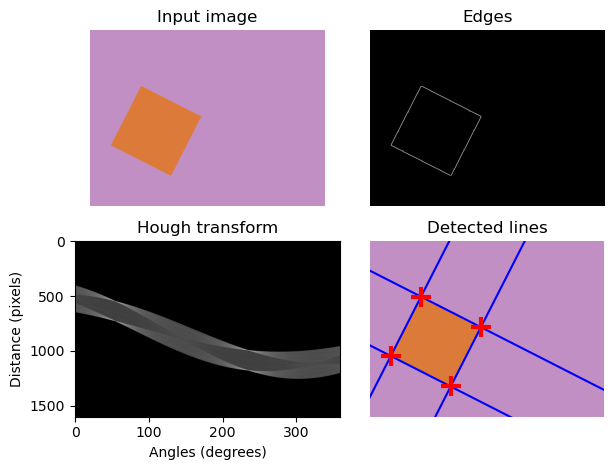

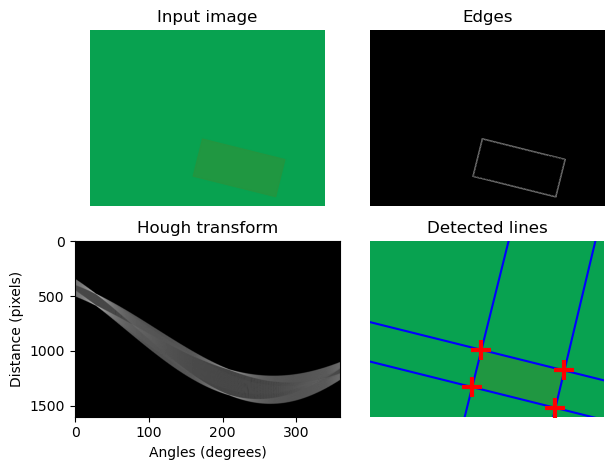

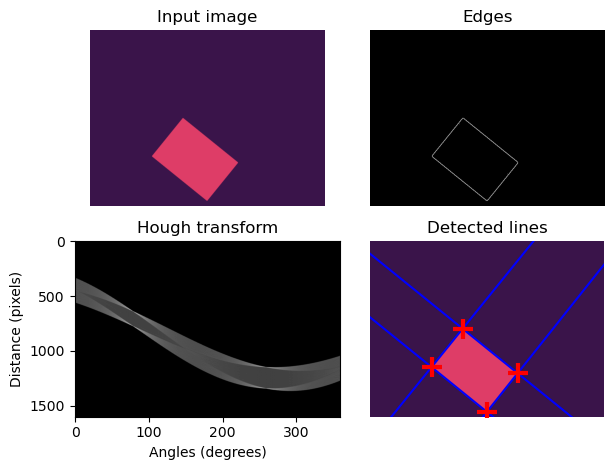

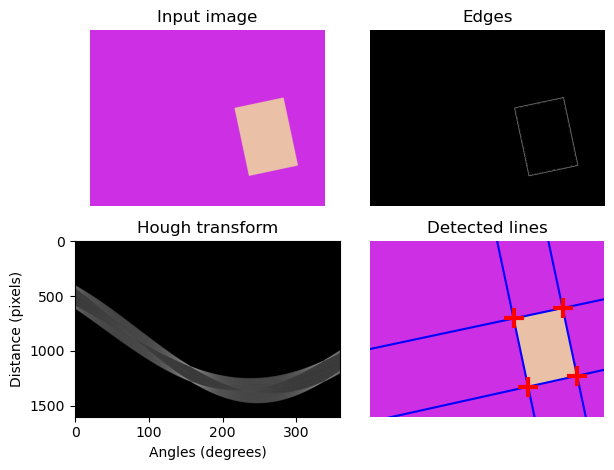

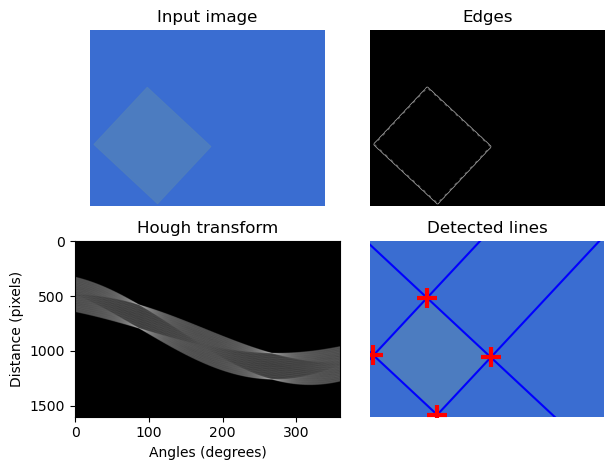

In [2]:
for i in range(1,6):
    img = imread(f'train\\images\\000{i}.png')[:,:,:3]

    edges = cv2.Canny(img,0,1)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(edges, theta=tested_angles)
    hpeaks = hough_line_peaks(h, theta, d, threshold=0.2 * h.max())
    fig, axes = plt.subplots(2, 2)
    ax = axes.ravel()

   
    ax[0].imshow(img,cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(edges,cmap=cm.gray)
    ax[1].set_title('Edges')
    ax[1].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
              np.rad2deg(theta[-1] + angle_step),
              d[-1] + d_step, d[0] - d_step]

    ax[2].imshow(np.log(1 + h),  cmap=cm.gray, aspect='auto')
    ax[2].set_title('Hough transform')
    ax[2].set_xlabel('Angles (degrees)')
    ax[2].set_ylabel('Distance (pixels)')
   

    ax[3].imshow(img, cmap=cm.gray)
    ax[3].set_ylim((480, 0))
    ax[3].set_xlim((0, 640))
    ax[3].set_axis_off()
    ax[3].set_title('Detected lines')
    lines = []
    for _, angle, dist in zip(*hpeaks):
        a = np.cos(angle)
        b = np.sin(angle)
        x0 = a*dist
        y0 = b*dist
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        lines.append([(x1,y1),(x2,y2)])
        ax[3].plot([x1,x2],[y1,y2],'-b')

    for i in range(len(lines)):
        A =  LineString(lines[i])
        for j in range(i,len(lines)):
            B = LineString(lines[j])
            int_pt = LineString(A).intersection(LineString(B))

            if not int_pt.is_empty:
                if int_pt.geom_type=='Point':
                    ax[3].plot(int_pt.x, int_pt.y,'r+', mew=3, ms=15)


    plt.tight_layout()
    plt.show()